This Notebook provide implementation of a news headline generator model with GRU based encoder decoder architecture for a given news content.

*   It uses a pre-trained BERT model for getting 
  - vector representation of word token in news summary which will be provided as input to encoder during training
  - when teacher forcing is enabled, vector representation of word token in news headline which will be provided as input to deocder during training

  NOTE:  Using BERT for getting vector representation of a word token **requires additional steps** as it requires context word token information also. it becomes tricky when we train model with batch inputs. **I have took care of these requirement**.


*   This also has **customized** implementation of Greedy and Beam search decoing as token from all previous time step is required at current decoding time step. **It became very tricky while implementing beama search as I had to maintain all the previous timestep token for multiple partially generated sub-sequences(beam-search-node).**   For this I have modified existing implementation 'PyTorch-Beam-Search' (https://github.com/budzianowski/PyTorch-Beam-Search-Decoding).


*   Also showcases some sample headline generation using both(beam/greedy) search based decoder using trained seq2seq model. although generated headline quality is very poor. 

In [ ]:
'''
mount google drive
'''
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
'''
install required libraries
'''
!pip install transformers

     |████████████████████████████████| 2.5MB 5.1MB/s 
     |████████████████████████████████| 3.3MB 16.1MB/s 
     |████████████████████████████████| 901kB 42.8MB/s 


In [ ]:
'''
import required packages
'''
import unicodedata
import re
import os
import random
import string
import itertools
import pickle
import glob

from queue import PriorityQueue
import operator

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import transformers

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords  

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
'''
configuration for deterministic results with multiple run
'''
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 

np.random.seed(seed)  
random.seed(seed) 

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
'''
pandas configuration for showing complete content of record
'''
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

In [ ]:
'''
defining vocabulary class
'''
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False #flag for trimming infrequent words
        self.num_words = 3  # Count SOS, EOS, PAD
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"} #adding default word tokens
        self.word2index = {}
        self.word2count = {}

    def addSentence(self, sentence):
        normalized_sentance=normalizeString(sentence)
        for word in normalized_sentance.split(' '):
            self.addWord(word)

    def addText(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
'''
load news data and show some sample 
'''
data_path='/content/gdrive/My Drive/Capstone_Project/Data/News_Data/news_article_with_sim_score.df'
article_df=pd.read_pickle(data_path)
no_of_headlines=[len(similar_headlines) for similar_headlines in article_df['similar_headline'].tolist()]
print('max no of similar headlines: ',max(no_of_headlines))
print('min no of similar headlines: ',min(no_of_headlines))
print('article_df shape:',article_df.shape)
article_df.sample(2)

max no of similar headlines:  13
min no of similar headlines:  0
article_df shape: (3000, 9)


,article_url,headline,content,author,published_date,read_more_source,similar_headline,similar_headline_url,similarity_scores
1801,https://inshorts.com/en/news/foot-of-missing-businesswoman-who-stole-₹74cr-from-clients-found-on-aus-beach-1614333830092,Foot of missing businesswoman who stole ₹74cr from clients found on Aus beach,"Australian police has said that campers have found the decomposed foot of missing businesswoman Melissa Caddick on a beach. Caddick, who allegedly stole A$13 million (over ₹74 crore) from her clients, disappeared on November 12 last year after federal police raided her home in Sydney. ""She may have taken her own life,"" police added.",None,2021-02-26T10:03:50.000Z,Daily Mail,"[Melissa Caddick: Missing fraud suspect's foot found on Australian beach, Melissa Caddick: remains of missing businesswoman found months after disappearance, Melissa Caddick dead, police confirm, after campers find her foot on NSW South Coast, Remains of missing businesswoman and 'conwoman' Melissa Caddick have been found, NSW Health In Australia Orders Radiology Solution From Sectra For Enterprise Access To Images, Sexy Croc &dash Entry #1372 &dash Data Clustering Contest]","[https://www.bbc.com/news/world-australia-56205519, https://www.theguardian.com/australia-news/2021/feb/26/melissa-caddick-missing-financial-adviser-found-dead-months-after-disappearance, https://www.abc.net.au/news/2021-02-26/melissa-caddick-found-dead/13195242, https://www.dailymail.co.uk/news/article-9301259/Remains-missing-businesswoman-conwoman-Melissa-Caddick-found.html, https://www.medicalbuyer.co.in/nsw-health-in-australia-orders-radiology-solution-from-sectra-for-enterprise-access-to-images/, https://entry1372-dcround2.usercontent.dev/20200529/categories/en/economy.html]","[0.58, 0.51, 0.34, 0.49, 0.19, 0.16]"
1190,https://inshorts.com/en/news/trumps-gab-account-compromised-as-hackers-target-platform-1614608033197,Trump's Gab account compromised as hackers target platform,"Former US President Donald Trump's Gab account was compromised along with the social network Gab CEO Andrew Torba's account. Torba revealed that the platform is being attacked by hackers who had earlier targeted law enforcement officers. According to Wired, around 70 gigabytes of Gab data representing over 40 million posts has been stolen and includes passwords, group passwords and messages.",None,2021-03-01T14:13:53.000Z,Business Insider India,"[Far-right social media Gab hacked, Trump's account targeted, Gab confirms it was hacked, Trump and Gab CEO accounts compromised during large-scale hack of alternative social media platform, Gab Hack Reveals Passwords And Private Messages, Hacktivists Attack Controversial Christian Conservative Social Media Site Gab, Leak 70 Gigabytes of Hacked Data Including Private Messages and Passwords, Gab: hack gives unprecedented look into platform used by far right, Gab Founder Andrew Torba Says Platform Was Hacked By Far-Left Activists : US : Christianity Daily, US Right-Wing Platform Gab Acknowledges it Was Hacked, Passwords, Private Posts Exposed in Hack of Gab Social Network]","[https://www.jpost.com/international/far-right-social-media-gab-hacked-trumps-account-targeted-660790, https://www.securitymagazine.com/articles/94733-gab-confirms-it-was-hacked, https://www.coloradopolitics.com/news/trump-and-gab-ceo-accounts-compromised-during-large-scale-hack-of-alternative-social-media-platform/article_379f06da-eb18-5226-b920-0833a591345f.html, https://www.forbes.com/sites/emmawoollacott/2021/03/02/gab-hack-reveals-passwords-and-private-posts/, https://www.cpomagazine.com/cyber-security/hacktivists-attack-controversial-christian-conservative-social-media-site-gab-leak-70-gigabytes-of-hacked-data-including-private-messages-and-passwords/, https://www.theguardian.com/world/2021/mar/11/gab-hack-neo-nazis-qanon-conspiracy-theories, http://www.christianitydaily.com/articles/11022/20210303/gab-founder-andrew-torba-says-platform-was-hacked-by-far-left-activi

In [ ]:
'''
converting existing one-to-many mapping to one-to-one mapping
'''
contents=[]
headlines=[]
similarity_scores=[]
count=0
for index, row in article_df.iterrows():
  contents.append(row['content'])
  headlines.append(row['headline'])
  similarity_scores.append(1.0)
  for similar_headline,similarity_score in zip(row['similar_headline'],row['similarity_scores']):
    contents.append(row['content'])
    headlines.append(similar_headline)
    similarity_scores.append(similarity_score)

print('no of records in training dataset: ',len(headlines))

no of records in training dataset:  23363


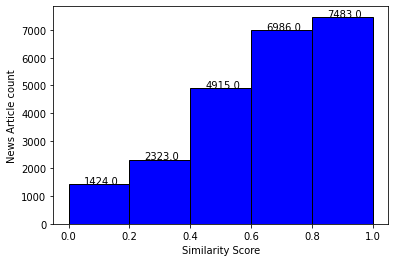

In [ ]:
'''
plotting similarity scrore distribution of similar headline with respect to reference headline
'''
import matplotlib.pyplot as plt
%matplotlib inline

plt.clf
#plt.hist(similarity_scores, bins=5,  edgecolor="black", color="blue") #normed=True, 
counts, bins, _=plt.hist(similarity_scores, bins=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],  edgecolor="black", color="blue") #normed=True, bins=[140, 150, 160, 175, 185, 200],
plt.ylabel('News Article count')
plt.xlabel('Similarity Score')
for count, bin in zip(counts, bins):
        plt.gca().text(bin + 0.05, count, str(count))  # +0.05 to center text

plt.show()

In [ ]:
'''
decide threshold for min and max no-of-word-token in headline 
'''
headline_len=[len(headline.split(" ")) for headline in headlines]
print('5th percentile length: ',np.quantile(headline_len, 0.05))
print('25th percentile length: ',np.quantile(headline_len, 0.25))
print('50th percentile length: ',np.quantile(headline_len, 0.50))
print('75th percentile length: ',np.quantile(headline_len, 0.75))
print('95th percentile length: ',np.quantile(headline_len, 0.95))
print('99th percentile length: ',np.quantile(headline_len, 0.99))

5th percentile length:  3.0
25th percentile length:  9.0
50th percentile length:  11.0
75th percentile length:  14.0
95th percentile length:  19.0
99th percentile length:  23.0


In [ ]:
'''
filtering news record based on similarity score and no-of-word-token in the headline
'''
min_word_token_in_headline=5
max_word_token_in_headline=16
min_similarity_score=0.5
summaries=[]
art_headlines=[]
for content,headline,similarity_score in zip(contents,headlines,similarity_scores):
   if(similarity_score>min_similarity_score):
     headline_len=len(headline.split(' '))
     if(min_word_token_in_headline <= headline_len <= max_word_token_in_headline):
      summaries.append(content)
      art_headlines.append(headline)

In [ ]:
'''
creating summary-headline pair and then randomly shuffle them
'''
summary_headline_pairs=list(zip(summaries,art_headlines))
random.shuffle(summary_headline_pairs)
len(summary_headline_pairs)

15306

In [ ]:
'''
get train and test dataset
'''
train_summary_headline_pairs=summary_headline_pairs[0:13500]
#train_summary_headline_pairs=summary_headline_pairs[0:100]#just for faster testing if code flow is working fine
test_summary_headline_pairs=summary_headline_pairs[13500:]
no_of_training_records=len(train_summary_headline_pairs)

In [ ]:
'''
creating training batches
'''
summary_train=[train_summary_headline_pair[0] for train_summary_headline_pair in train_summary_headline_pairs]
headline_train=[train_summary_headline_pair[1] for train_summary_headline_pair in train_summary_headline_pairs]

In [ ]:
'''
load Bert-Model and Tokeninzer using predefined weights
distilbert-base-uncased' model is uncased: it does not make a difference between english and English. 
'''
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
'''
initialize BOS and EOS token
'''
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token
print('SOS token id: ',tokenizer.bos_token_id)
print('EOS token id: ',tokenizer.eos_token_id)

SOS token id:  101
EOS token id:  102


In [ ]:
'''
tokenize summary and headline
'''
tokenized_summaries=[tokenizer.encode(summary, add_special_tokens=True) for summary in summaries]
tokenized_headlines=[tokenizer.encode(headline, add_special_tokens=True) for headline in art_headlines]

In [ ]:
'''
get maximum encoder and decoder length
'''
max_encoder_len=max([len(tokenized_summary) for tokenized_summary in tokenized_summaries] )
max_decoder_len=max([len(tokenized_headline) for tokenized_headline in tokenized_headlines] )
(max_encoder_len,max_decoder_len)

(125, 40)

In [ ]:
'''
function for providing emebded representation of BOS token at first timestep of decoding for complete batch
'''
def get_initial_decoder_ip(batch_size):
  sos_token_tensor=torch.tensor([[tokenizer.bos_token_id]])
  with torch.no_grad():
    last_hidden_states = model(sos_token_tensor)
  SOS_token_bert_vector=last_hidden_states[0]
  SOS_token_bert_vector=torch.squeeze(SOS_token_bert_vector, 0)
  decoder_input = torch.tensor([SOS_token_bert_vector.numpy() for _ in range(batch_size)])
  print('decoder_input shape: ',decoder_input.shape)
  decoder_input=decoder_input.permute(1,0,2)
  print('decoder_input shape: ',decoder_input.shape)
  return decoder_input

In [ ]:
'''
just for testing
'''
get_initial_decoder_ip(32)

decoder_input shape:  torch.Size([32, 1, 768])
decoder_input shape:  torch.Size([1, 32, 768])


tensor([[[ 0.5072,  0.1282, -0.2608,  ...,  0.3472, -1.0410,  0.1384],
         [ 0.5072,  0.1282, -0.2608,  ...,  0.3472, -1.0410,  0.1384],
         [ 0.5072,  0.1282, -0.2608,  ...,  0.3472, -1.0410,  0.1384],
         ...,
         [ 0.5072,  0.1282, -0.2608,  ...,  0.3472, -1.0410,  0.1384],
         [ 0.5072,  0.1282, -0.2608,  ...,  0.3472, -1.0410,  0.1384],
         [ 0.5072,  0.1282, -0.2608,  ...,  0.3472, -1.0410,  0.1384]]])

In [ ]:
'''
tokenize news summary and headline
'''
encoder_max_length=512 
decoder_max_length=40 
inputs = tokenizer(summary_train, padding="max_length", truncation=True, max_length=max_encoder_len)
outputs = tokenizer(headline_train, padding="max_length", truncation=True, max_length=max_decoder_len)

In [ ]:
'''
instance of class Batch_Data represent input to the encoder decoder model for a batch
'''
class Batch_Data:
  def __init__(self, batch_ip_vector, batch_ip_length, batch_op_vector, batch_op_token_idxs, batch_mask):
    self.batch_ip_vector=batch_ip_vector
    self.batch_ip_length=batch_ip_length
    self.batch_op_vector=batch_op_vector
    self.batch_op_token_idxs=batch_op_token_idxs
    self.batch_mask=batch_mask

In [ ]:
'''
run this cell only once.
compute BERT based representation of news summary and headline and store it on drive.
this will help in faster training, as we don't have to get bert based vector representation of headline and summary during every training iteration. 
'''
batch_start=0
batch_end=0
end=len(inputs.input_ids)#total no of records 13000
batch_size=32
summary_vector=None

inputs_input_ids = np.array(inputs.input_ids)
inputs_attention_mask = np.array(inputs.attention_mask)
outputs_input_ids = np.array(outputs.input_ids)
outputs_attention_mask = np.array(outputs.attention_mask)

while batch_end<end:
  batch_end=batch_start+batch_size
  if batch_end<end:
    pass #do nothing
  else:
    batch_end=end
  print('batch_start: ',batch_start,' batch_end: ',batch_end)
  summary_batch=inputs_input_ids[batch_start:batch_end,:]
  summary_length_batch=[np.count_nonzero(summary==0) for summary in summary_batch]
  headline_batch=outputs_input_ids[batch_start:batch_end,:]
  #print('summary_batch: ',summary_batch.shape)
  #print('headline_batch: ',headline_batch.shape)
  attention_mask_summary = inputs_attention_mask[batch_start:batch_end,:]
  attention_mask_headline = outputs_attention_mask[batch_start:batch_end,:]
  #print('attention_mask_summary: ',attention_mask_summary.shape)
  #print('attention_mask_headline: ',attention_mask_headline.shape)
  attention_mask_summary_t = torch.tensor(attention_mask_summary)
  attention_mask_headline_t = torch.BoolTensor(attention_mask_headline)
  summary_batch_t = torch.tensor(summary_batch) 
  headline_batch_t = torch.tensor(headline_batch)  
  with torch.no_grad():
    last_hidden_states = model(summary_batch_t, attention_mask=attention_mask_summary_t)
  summary_batch_vector=last_hidden_states[0]
  with torch.no_grad():
    last_hidden_states = model(headline_batch_t, attention_mask=attention_mask_headline_t)
  headline_batch_vector=last_hidden_states[0]

  batch_data=Batch_Data(summary_batch_vector,summary_length_batch,headline_batch_vector,headline_batch_t,attention_mask_headline_t)
  '''print('batch_ip_vector: ',batch_data.batch_ip_vector.shape, "type: ",type(batch_data.batch_ip_vector))
  print('batch_op_vector: ',batch_data.batch_op_vector.shape, "type: ",type(batch_data.batch_op_vector))
  print('batch_op_token_idxs: ',batch_data.batch_op_token_idxs.shape, "type: ",type(batch_data.batch_op_token_idxs))
  print('batch_mask: ',batch_data.batch_mask.shape, "type: ",type(batch_data.batch_mask))
  print('batch_ip_length: ',len(batch_data.batch_ip_length), "type: ",type(batch_data.batch_ip_length))'''
  batch_file_path='/content/gdrive/My Drive/Capstone_Project/Data/Bert_vectors/batch_data/batch_'+str(batch_start)+'_'+str(batch_end)+'.pickle'
  with open(batch_file_path, 'wb') as file_handle:
    pickle.dump(batch_data, file_handle, protocol=pickle.HIGHEST_PROTOCOL)
  batch_start=batch_end

In [ ]:
'''
utility function for creating batche from stored BERT based news headline and summary vector 
'''
def prepare_batches():
  training_batch_location='/content/gdrive/My Drive/Capstone_Project/Data/Bert_vectors/batch_data/*'
  batch_files=glob.glob(training_batch_location)
  random.shuffle(batch_files)
  #print(batch_files)
  return batch_files

def get_data_for_current_iteration(iteration_index,batch_files,batch_size=32):
  no_of_files_per_batch=int(batch_size/32) #every batch file has 32 training records and batch size shalll be multiple of 32
  start_idx=iteration_index*no_of_files_per_batch
  end_idx=start_idx+no_of_files_per_batch
  files_for_this_iter=batch_files[start_idx:end_idx]#end_idx is exclusive and start_idx is inclusive
  print('files_for_this_iter: ',files_for_this_iter)
  batch_data=None
  for file in files_for_this_iter:
    #print('for loop')
    with open(file, 'rb') as file_handle:
      batch_data_loaded=pickle.load(file_handle)  
      #print('*************1')
    if (batch_data==None):
      #print('*************2')
      batch_data=batch_data_loaded
      #print('*************3')
    else:
      #print('*************4')
      batch_ip_vector=torch.vstack((batch_data.batch_ip_vector,batch_data_loaded.batch_ip_vector))
      batch_ip_length=batch_data.batch_ip_length + batch_data_loaded.batch_ip_length
      batch_op_vector=torch.vstack((batch_data.batch_op_vector,batch_data_loaded.batch_op_vector))
      batch_op_token_idxs=torch.vstack((batch_data.batch_op_token_idxs,batch_data_loaded.batch_op_token_idxs))
      batch_mask=torch.vstack((batch_data.batch_mask,batch_data_loaded.batch_mask))
      batch_data=Batch_Data(batch_ip_vector,batch_ip_length,batch_op_vector,batch_op_token_idxs,batch_mask)
  #print('*************5')
  return batch_data

In [ ]:
'''
test function for ip data generation for a given training iteration
'''
def trainIters():
  num_sample=128 #TODO need to be initialized prperly
  batch_size=64 #TODO need to be initialized prperly
  n_epoch=2 #TODO need to be initialized prperly
  max_target_len=44 #TODO need to be initialized prperly
  num_iteration=int(num_sample/batch_size)
  for epoch in range(n_epoch):
    print('epoch is in progress: ',epoch+1)  
    batch_files=prepare_batches()
    training_batches =[] 
    for iteration_index in range(num_iteration):
      print('*********************iteration index:',str(iteration_index),'*********************')
      # Run a training iteration with batch
      # Extract fields from batch
      batch_data=get_data_for_current_iteration(iteration_index,batch_files,batch_size)
      input_variable,lengths,target_variable,batch_op_token_idxs,mask =batch_data.batch_ip_vector,batch_data.batch_ip_length,batch_data.batch_op_vector,batch_data.batch_op_token_idxs,batch_data.batch_mask
      input_variable=input_variable.permute(1,0,2)
      input_variable=input_variable.permute(1,0,2)
      lengths = torch.tensor(lengths)
      print('input_variable: ',input_variable.shape, "type: ",type(input_variable))
      print('target_variable: ',target_variable.shape, "type: ",type(target_variable))
      print('mask: ',mask.shape, "type: ",type(mask))
      print('batch_ip_length: ',lengths.shape, "type: ",type(lengths))

In [ ]:
'''
test ip data generation for a given training iteration
'''
trainIters()

epoch is in progress:  1
*********************iteration index: 0 *********************
files_for_this_iter:  ['/content/gdrive/My Drive/Capstone_Project/Data/Bert_vectors/batch_data/batch_5888_5920.pickle', '/content/gdrive/My Drive/Capstone_Project/Data/Bert_vectors/batch_data/batch_9216_9248.pickle']
input_variable:  torch.Size([64, 125, 768]) type:  <class 'torch.Tensor'>
target_variable:  torch.Size([64, 40, 768]) type:  <class 'torch.Tensor'>
mask:  torch.Size([64, 40]) type:  <class 'torch.Tensor'>
batch_ip_length:  torch.Size([64]) type:  <class 'torch.Tensor'>
*********************iteration index: 1 *********************
files_for_this_iter:  ['/content/gdrive/My Drive/Capstone_Project/Data/Bert_vectors/batch_data/batch_12768_12800.pickle', '/content/gdrive/My Drive/Capstone_Project/Data/Bert_vectors/batch_data/batch_2304_2336.pickle']
input_variable:  torch.Size([64, 125, 768]) type:  <class 'torch.Tensor'>
target_variable:  torch.Size([64, 40, 768]) type:  <class 'torch.Tenso

In [ ]:
'''
GRU based encoder class without any embedding layer (as input will precomputed bert vector representation of news data)
'''
class Encoder(nn.Module):
  def __init__(self, embbed_dim, hidden_dim, num_layers):
       super(Encoder, self).__init__()
       #set the encoder input dimesion , embbed dimesion, hidden dimesion, and number of layers 
       self.hidden_dim = hidden_dim
       self.num_layers = num_layers
       self.embbed_dim=embbed_dim
       #intialize the GRU to take the input dimetion of embbed, and output dimention of hidden and
       #set the number of gru layers
       self.gru = nn.GRU(self.embbed_dim, self.hidden_dim, num_layers=self.num_layers)

  def forward(self, input_seq, input_lengths, hidden=None):
    print('inside encoder forward function || input_seq shape: ',input_seq.shape )
    print('inside encoder forward function || input_lengths shape: ',input_lengths.shape )
    if(hidden!=None):
      torch.set_printoptions(threshold=10000)
      print('inside encoder forward function || hidden shape: ',hidden )
    # Pack padded batch of sequences for RNN module
    
    # Forward pass through GRU
    outputs, hidden = self.gru(input_seq, hidden)
    '''
    packed = nn.utils.rnn.pack_padded_sequence(input_seq, input_lengths)
    outputs, hidden = self.gru(packed, hidden)##TODO 
    outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
    '''
    # Unpack padding
    
    #print('inside encoder forward function || outputs shape: ',outputs.shape )
    #print('inside encoder forward function || hidden shape: ',hidden )
    #print('inside encoder forward function || outputs[:, : ,self.hidden_dim:] shape: ',outputs[:, : ,self.hidden_dim:].shape )
    # Sum bidirectional GRU outputs
    #outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
    # Return output and final hidden state
    print('inside encoder forward function || outputs shape: ',outputs.shape )
    print('inside encoder forward function || hidden shape: ',hidden.shape )
    return outputs, hidden   

In [ ]:
'''
Luong attention layer
'''
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [ ]:
'''
GRU with Luong Attn based Decoder class 
'''
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embbed_dim, hidden_size, output_size, num_layers=1 ):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.embbed_dim=embbed_dim
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # Define layers
        self.gru = nn.GRU(self.embbed_dim, self.hidden_size, self.num_layers)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        #print("decoder forward 1 embedded shape: ",embedded.shape)
        #embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(input_step, last_hidden)
        #print("decoder forward 2 rnn_output shape: ",rnn_output.shape)
        #print("decoder forward 2 hidden shape: ",hidden.shape)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        #print("decoder forward 3 attn_weights shape: ",attn_weights.shape)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        #print("decoder forward 4 context shape: ",context.shape)
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        #print("decoder forward 5 rnn_output.squeeze shape: ",rnn_output.shape)
        #print("decoder forward 5 context.squeeze shape: ",context.shape)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        #print("decoder forward 6 concat_input shape: ",concat_input.shape)
        #print("decoder forward 6 concat_output shape: ",concat_output.shape)        
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        #print("decoder forward 7 output shape: ",output.shape)
        output = F.softmax(output, dim=1)
        #print("decoder forward 8 output shape: ",output.shape)
        # {Return word2 output} {and output} {output} and final hidden state
        return output, hidden

In [ ]:
'''
loss function that calculates the average negative log likelihood of the elements that correspond to a 1 in the mask tensor
'''
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [ ]:
'''
function for performing a single training iteration
'''
def train(input_variable, lengths, target_variable, target_op_token_idxs, mask, max_target_len, encoder, decoder,
          encoder_optimizer, decoder_optimizer, batch_size, clip,decoder_ip_initial, teacher_forcing_ratio=1):
    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    print('inside train function decoder_ip_initial shape: ',decoder_ip_initial.shape)
    decoder_input = decoder_ip_initial#sos token for all the training sample in a given batch
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.num_layers] #this important and handle scenario where no of layer for GRU varries in encoder decoder
    #TODO check why 'encoder_hidden[:decoder.n_layers]'? not 'encoder_hidden[:encoder.n_layers]'
    #print('inside function train decoder_hidden: ',decoder_hidden.shape)
    #print('inside function train encoder_hidden[:encoder.num_layers]: ',encoder_hidden[:encoder.num_layers].shape)
    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False #TODO need to work on this
    #print('before the decoder forward pass')
    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        #iterate through timesteps for decoder 
        print('teacher forcing will be used for this batch')
        for timestep in range(1,max_target_len):
            #print('before decoder forward pass: ')
            #print('decoder_input shape: ',decoder_input.shape)
            #print('decoder_hidden shape: ',decoder_hidden.shape)
            #print('encoder_outputs shape: ',encoder_outputs.shape)
            print('timestep: ',timestep,' inside train function1: ',decoder_input.shape)
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)#(decoder_input, decoder_hidden, encoder_outputs)
            # Teacher forcing: next input is current target
            print('timestep: ',timestep,' inside train function2: ',decoder_input.shape)
            decoder_input = torch.unsqueeze(target_variable[timestep],0)#[1,64] use next timestamp token from target seq  as ip to decoder at nexe time step
            #print('target_variable[timestep] shape: ',target_variable[timestep].shape)#[64]
            #print('target_variable[timestep].view(1, -1) shape: ',target_variable[timestep].view(1, -1).shape)#[1,64]
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_op_token_idxs[timestep], mask[timestep])
            print('timestep : ',timestep,' mask_loss: ',mask_loss,' loss: ',loss)
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
            non_padding_token_count=mask[timestep+1].sum()#non_padding_token_count for next timestep
            #print('non_padding_token_count: ',non_padding_token_count)
            if(non_padding_token_count==0):#all tokens are padding token for next timestep for all records in batches 
              break
    else:
        print('teacher forcing won\'t be used for this batch')
        for timestep in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [ ]:
'''
function responsible for running n epoch of training given the passed models, optimizers, data etc.
'''
def trainIters(n_epoch, batch_size, num_sample, max_target_len, encoder, decoder, encoder_optimizer, decoder_optimizer, decoder_ip_initial, print_every, clip):
  num_iteration=int(num_sample/batch_size)
  num_iteration=2 #TODO need to commented just for testing if complete training code is working fine
  for epoch in range(n_epoch):
    print('epoch is in progress: ',epoch+1)  
    batch_files=prepare_batches()
    print_loss=0
    for iteration_index in range(num_iteration):
      print('*********************iteration index:',str(iteration_index),'*********************')
      # Run a training iteration with batch
      # Extract fields from batch
      batch_data=get_data_for_current_iteration(iteration_index,batch_files,batch_size)
      input_variable,lengths,target_variable,target_op_token_idxs,mask =batch_data.batch_ip_vector,batch_data.batch_ip_length,batch_data.batch_op_vector,batch_data.batch_op_token_idxs,batch_data.batch_mask
      input_variable=input_variable.permute(1,0,2)
      target_variable=target_variable.permute(1,0,2)
      target_op_token_idxs=target_op_token_idxs.permute(1,0)
      mask=mask.permute(1,0)
      lengths = torch.tensor(lengths)
      print('input_variable: ',input_variable.shape, "type: ",type(input_variable))
      print('target_variable: ',target_variable.shape, "type: ",type(target_variable))
      print('target_op_token_idxs: ',target_op_token_idxs.shape, "type: ",type(target_op_token_idxs))
      #torch.set_printoptions(profile="full")
      #print('target_op_token_idxs: ',target_op_token_idxs)
      #torch.set_printoptions(profile="default") # reset#
      #break
      print('mask: ',mask.shape, "type: ",type(mask))
      print('batch_ip_length: ',lengths.shape, "type: ",type(lengths))
      
      print('inside trainIters before calling train')
      loss = train(input_variable, lengths, target_variable, target_op_token_idxs, mask, max_target_len, encoder, decoder,
          encoder_optimizer, decoder_optimizer, batch_size, clip,decoder_ip_initial, teacher_forcing_ratio=1)
      print('inside trainIters after calling train')
      print_loss += loss
      print_every=1 #print after every 10 iteration
      # Print training progress
      if iteration_index % print_every == 0: 
        print_loss_avg = print_loss / print_every
        print('Epoch: ',epoch+1,' Iteration: ',iteration_index,' avg_loss: ',print_loss_avg)
        print_loss = 0

In [ ]:
'''
Configure training and optimization parameter
'''
encoder_n_layers=1 
decoder_n_layers=1

clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_epoch = 1 #10
print_every = 10
save_every = 500

##
num_sample = 128 #padded_summaries.shape
max_target_len = 40 #headline_max_len


##
vocab_len=30522 #
output_size=30521 # BERT vocab_size  30522
embed_size = 768
hidden_size = 256
batch_size = 32
#num_iteration = 100000


# Initialize encoder & decoder models
encoder = Encoder(embed_size, hidden_size, encoder_n_layers)
attn_model = 'dot'
decoder = LuongAttnDecoderRNN(attn_model, embed_size, hidden_size, output_size, decoder_n_layers)

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

decoder_ip_initial=get_initial_decoder_ip(batch_size)

Building optimizers ...
decoder_input shape:  torch.Size([32, 1, 768])
decoder_input shape:  torch.Size([1, 32, 768])


In [ ]:
'''
train the model for specified no of epoch
'''
trainIters(n_epoch, batch_size, num_sample, max_target_len, encoder, decoder, encoder_optimizer, decoder_optimizer, decoder_ip_initial, print_every, clip)

epoch is in progress:  1
*********************iteration index: 0 *********************
files_for_this_iter:  ['/content/gdrive/My Drive/Capstone_Project/Data/Bert_vectors/batch_data/batch_384_416.pickle']
input_variable:  torch.Size([125, 32, 768]) type:  <class 'torch.Tensor'>
target_variable:  torch.Size([40, 32, 768]) type:  <class 'torch.Tensor'>
target_op_token_idxs:  torch.Size([40, 32]) type:  <class 'torch.Tensor'>
mask:  torch.Size([40, 32]) type:  <class 'torch.Tensor'>
batch_ip_length:  torch.Size([32]) type:  <class 'torch.Tensor'>
inside trainIters before calling train
inside encoder forward function || input_seq shape:  torch.Size([125, 32, 768])
inside encoder forward function || input_lengths shape:  torch.Size([32])
inside encoder forward function || outputs shape:  torch.Size([125, 32, 256])
inside encoder forward function || hidden shape:  torch.Size([1, 32, 256])
inside train function decoder_ip_initial shape:  torch.Size([1, 32, 768])
teacher forcing will be used f

In [ ]:
'''
beam search node
'''
class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
        '''
        :param hiddenstate:
        :param previousNode:
        :param wordId:
        :param logProb:
        :param length:
        '''
        self.h = hiddenstate
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.leng = length

    def eval(self, alpha=1.0):
        reward = 0
        return self.logp / float(self.leng - 1 + 1e-6) + alpha * reward

    def __lt__(self, other):
        return self.leng < other.leng

    def __gt__(self, other):
        return self.leng > other.leng

In [ ]:
'''
get context token for a beam search node
'''
def get_context_tokens(beam_search_node):
  context_tokens=[]
  while(beam_search_node != None):
    word_id=beam_search_node.wordid
    context_tokens.append(word_id)
    beam_search_node=beam_search_node.prevNode
  context_tokens.reverse()
  return context_tokens

In [ ]:
'''
beam search decoder
'''
def beam_decode(decoder, target_tensor, decoder_hiddens, encoder_outputs=None):
        '''
        :param target_tensor: target indexes tensor of shape [B, T] where B is the batch size and T is the maximum length of the output sentence
        :param decoder_hiddens: input tensor of shape [1, B, H] for start of the decoding
        :param encoder_outputs: if you are using attention mechanism you can pass encoder outputs, [T, B, H] where T is the maximum length of input sentence
        :return: decoded_batch
        '''
        #target_tensor = target_tensor.permute(1, 0)
        batch_size = target_tensor.shape[1]
        max_seq_len = target_tensor.shape[0]
        #print('1. inside beam decode function batch_size: ',batch_size)
        beam_width = 10
        topk = 3 # how many sentence do you want to generate
        decoded_batch = []

        # decoding goes sentence by sentence
        for idx in range(batch_size):  # batch_size
            if isinstance(decoder_hiddens, tuple):  # LSTM case
                decoder_hidden = (
                    decoder_hiddens[0][:, idx, :].unsqueeze(0), decoder_hiddens[1][:, idx, :].unsqueeze(0))
            else:
                decoder_hidden = decoder_hiddens[:, idx, :].unsqueeze(0)  # [1, B, H]=>[1,H]=>[1,1,H] #final hidden vector coming out from encoder for current seq
            encoder_output = encoder_outputs[:, idx, :].unsqueeze(1)  # [T,B,H]=>[T,H]=>[T,1,H] #encoder's output coming out from encoder for current seq

            # Start with the start of the sentence token
            #decoder_input = torch.LongTensor([SOS_token]).cuda()
            decoder_input_token=torch.LongTensor([tokenizer.eos_token_id])
            decoder_input = get_initial_decoder_ip(1) # here we are processing for one seq of batch so passing batch_size=1 
            #decoder_input = torch.ones(1, device=device, dtype=torch.long) * SOS_token
            # print('1. inside function beam_decode  shape of decoder_input: ',decoder_input.shape)

            # Number of sentence to generate
            endnodes = []
            number_required = min((topk + 1), topk - len(endnodes))

            # starting node -  hidden vector, previous node, word id, logp, length
            node = BeamSearchNode(decoder_hidden, None, decoder_input_token, 0, 1)
            nodes = PriorityQueue()

            # start the queue
            nodes.put((-node.eval(), node))
            qsize = 1

            loop_count=0

            # start beam search
            while True:
                #print('current loop_count is: ',loop_count,' size of priority queue: ',nodes.qsize())
                '''
                if(timestep==max_seq_len):
                  break
                '''
                # give up when decoding takes too long
                if qsize > 2000: break

                # fetch the best node
                #print('priorityQueue size before retrieving: ',nodes.qsize())
                score, n = nodes.get()
                #print('priorityQueue size after retrieving: ',nodes.qsize())
                decoder_input_token = n.wordid.item()
                decoder_hidden = n.h
                #print('2. inside function beam_decode  tokenizer.eos_token_id: ',(decoder_input_token,n.prevNode))
                if decoder_input_token == tokenizer.eos_token_id and n.prevNode != None:
                    #print('decoder_input_token is: ',decoder_input_token,' number_required: ',number_required)
                    endnodes.append((score, n))
                    # if we reached maximum # of sentences required
                    if len(endnodes) >= number_required:
                        break
                    else:
                        continue
                context_tokens = get_context_tokens(n)
                # print('1. context_tokens: ',context_tokens)
                last_token_index=len(context_tokens)-1
                with torch.no_grad():
                  last_hidden_states = model(torch.tensor([context_tokens]))
                bert_vector__for_context_tokens=last_hidden_states[0]#(batch_size*max_op_len*768)
                # print('2. shape of ip to bert encoding: ',torch.tensor([context_tokens]).shape)
                # print('3. bert_vector__for_context_tokens shape: ',bert_vector__for_context_tokens.shape)
                decoder_input=torch.unsqueeze(bert_vector__for_context_tokens.permute(1,0,2)[last_token_index],0)
                loop_count=loop_count+1
                # print('4. before decoder forward pass decoder_input shape',decoder_input.shape)
                #decoder_input = torch.unsqueeze(decoder_input, 0)
                # decode for one step using decoder
                decoder_output, decoder_hidden =  decoder(decoder_input, decoder_hidden, encoder_output)
                # PUT HERE REAL BEAM SEARCH OF TOP
                log_prob, indexes = torch.topk(decoder_output, beam_width)#top 'beam_width(10)' log probability arranged in descending order and their indexes
                #print('after decoder forward pass (log_prob, indexes)',(log_prob, indexes))
                nextnodes = []

                for new_k in range(beam_width):
                    decoded_t = indexes[0][new_k].view(-1)
                    log_p = log_prob[0][new_k].item()

                    node = BeamSearchNode(decoder_hidden, n, decoded_t, n.logp + log_p, n.leng + 1)#hidden vector, previous node, word id, logp, length
                    score = -node.eval()
                    nextnodes.append((score, node))

                # put them into queue
                for i in range(len(nextnodes)):
                    score, nn = nextnodes[i]
                    nodes.put((score, nn))
                    # increase qsize
                qsize += len(nextnodes) - 1

            # choose nbest paths, back trace them
            if len(endnodes) == 0:
                endnodes = [nodes.get() for _ in range(topk)]

            utterances = []
            for score, n in sorted(endnodes, key=operator.itemgetter(0)):
                utterance = []
                utterance.append(n.wordid)
                # back trace
                while n.prevNode != None:
                    n = n.prevNode
                    utterance.append(n.wordid)

                utterance = utterance[::-1]
                utterances.append(utterance)

            decoded_batch.append(utterances)

        return decoded_batch

In [ ]:
'''
greedy search decoder
'''
def greedy_decode(decoder,trg, decoder_hidden, encoder_outputs, ):
        '''
        :param target_tensor: target indexes tensor of shape [B, T] where B is the batch size and T is the maximum length of the output sentence
        :param decoder_hidden: input tensor of shape [1, B, H] for start of the decoding
        :param encoder_outputs: if you are using attention mechanism you can pass encoder outputs, [T, B, H] where T is the maximum length of input sentence
        :return: decoded_batch
        '''
        seq_len, batch_size = trg.size()

        decoded_batch = torch.zeros((batch_size, seq_len)).int()
        #print((decoded_batch.dtype))
        # decoder_input = torch.LongTensor([[EN.vocab.stoi['<sos>']] for _ in range(batch_size)]).cuda()
        #decoder_input = Variable(trg.data[0, :])  # sos
        decoder_input = get_initial_decoder_ip(batch_size)
        #print('1. inside greedy_decode decoder_input shape : ',decoder_input.shape)
        for timestep in range(seq_len):
            decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden, encoder_outputs)
            #print('2. inside greedy_decode decoder_output shape : ',decoder_output.shape)# [1, 30521]
            #print('3. inside greedy_decode decoder_hidden shape : ',decoder_hidden.shape)
            topv, topi = decoder_output.data.topk(1)  
            #print('topv, topi: ',(topv, topi))
            topi = topi.view(-1)
            decoded_batch[:, timestep] = topi   
            attention_mask_decoded_batch = torch.where(decoded_batch != 0, 1, 0)        
            decoder_input = topi.detach().view(-1)
            #print('4 inside greedy_decode decoder_input 2 : ',decoder_input)
            decoder_input = torch.unsqueeze(decoder_input, 0)
            #print('5 inside greedy_decode decoder_input 3 : ',decoder_input)
            with torch.no_grad():
              last_hidden_states = model(decoded_batch, attention_mask=attention_mask_decoded_batch)
            decoded_batch_vector=last_hidden_states[0]#(batch_size*max_op_len*768)
            decoder_input=torch.unsqueeze(decoded_batch_vector.permute(1,0,2)[timestep],0)
            #print('6 inside greedy_decode decoder_input 5 : ',decoder_input.shape)
        return decoded_batch

In [ ]:
'''
decode based on provided search(greedy/beam) method
'''
def decode(encoder, decoder,input_seq, input_length, trg, method='beam-search'):
    # Forward input through encoder model
    encoder_outputs, encoder_hidden = encoder(input_seq, input_length)
    #encoder_output, encoder_hidden = encoder(src)  # [27, 32]=> =>[27, 32, 512],[4, 32, 512]
    encoder_hidden = encoder_hidden[:decoder.num_layers]  # [4, 32, 512][1, 32, 512]
    #print('inside decode function encoder_outputs shape: ',encoder_outputs.shape)
    #print('inside decode function encoder_hidden shape: ',encoder_hidden.shape)
    #print('inside decode function trg shape: ',trg.shape)
    if method == 'beam-search':
        return beam_decode(decoder,trg, encoder_hidden, encoder_outputs)
    else:
        return greedy_decode(decoder,trg, encoder_hidden, encoder_outputs)

In [ ]:
'''
function for generating op sequence for a given input seq
'''
MAX_LENGTH=15
def evaluate(encoder, decoder, summary_batch_vector, summary_length_batch, max_length=MAX_LENGTH,search_method='greedy-search'):
  #input_variable,lengths,target_variable,target_op_token_idxs,mask =batch_data.batch_ip_vector,batch_data.batch_ip_length,batch_data.batch_op_vector,batch_data.batch_op_token_idxs,batch_data.batch_mask
  input_variable=summary_batch_vector.permute(1,0,2)
  lengths = torch.tensor(summary_length_batch)
  #target_variable=target_variable.permute(1,0,2)
  #target_op_token_idxs=target_op_token_idxs.permute(1,0)
  #mask=mask.permute(1,0)
  trg=torch.zeros([max_length,1], dtype=torch.long).to(device)
  if (search_method=='greedy-search'):
    decoded_batch=decode(encoder, decoder,input_variable, lengths, trg, method='greedy-search')
    #print('decoded_batch: ',decoded_batch)
    decoded_words = [tokenizer.decode(token_idx) for token_idx in decoded_batch[0]]
  else:
    decoded_batches=decode(encoder, decoder,input_variable, lengths, trg, method='beam-search')
    decoded_batches=decoded_batches[0]
    #print('decoded_batch: ',decoded_batches)
    decoded_words=[]
    for decoded_batch in decoded_batches:
      decoded_words.append([tokenizer.decode(token_idx) for token_idx in decoded_batch])
    print('decoded_words: ',decoded_words)
  return decoded_words

In [ ]:
  '''
  generate sequence for a given input news summary using 'beam-search' 
  '''
  summary_headline=summary_headline_pairs[12]
  content=summary_headline[0]
  ref_headline=summary_headline[1]
  print("article content: ")
  print(content)
  print("reference headline: ",ref_headline)

  summary_test=[content]
  summary_test_tokens=[tokenizer.encode(summary, add_special_tokens=True) for summary in summary_test]
  summary_test_tokens=sorted(summary_test_tokens, key=lambda x: len(x), reverse=True)#sort summaries based on no of tokens in them
  #print('****************** no of tokens in test summary: ',len(summary_test_tokens[0]))
  
  #adding PAD token to get uniform size
  PAD_TOKEN=0 #BERT tokenizer.decode(0) will give you 'PAD' as a token
  summary_max_len = 0
  for summary_token in summary_test_tokens:
    if len(summary_token) > summary_max_len:
        summary_max_len = len(summary_token)

  #print('maximum no of tokens for a summary sequence in given batch: ',summary_max_len)
  summary_max_len=125 # TODO remove this line and check ideally it should be computed 'summary_max_len'

  padded_summaries = np.array([summary_token + [PAD_TOKEN]*(summary_max_len-len(summary_token)) for summary_token in summary_test_tokens])
  #print('after padding summary data shape: ',padded_summaries.shape)
  summary_batch=padded_summaries
  summary_length_batch=[np.count_nonzero(summary!=0) for summary in summary_batch]
  attention_mask_summary = np.where(summary_batch != 0, 1, 0)
  attention_mask_summary_t = torch.tensor(attention_mask_summary)
  summary_batch_t = torch.tensor(summary_batch) 
  #print('summary_length_batch',summary_length_batch)
  
  with torch.no_grad():
    last_hidden_states = model(summary_batch_t, attention_mask=attention_mask_summary_t)
  summary_batch_vector=last_hidden_states[0]

  #print('summary_batch_vector shape: ',summary_batch_vector.shape)

  ##
  op_headlines=evaluate(encoder, decoder, summary_batch_vector, summary_length_batch, max_length=MAX_LENGTH,search_method='beam-search')
  print('generated headline from beam search decoding: ')
  for op_headline in op_headlines:
    print('generated headlie: ', " ".join(op_headline))

article content: 
Boeing CEO David Calhoun received a total compensation of over $21 million in 2020 after he gave up $3.6 million in the form of salary and bonuses amid the COVID-19 pandemic. He took $269,231 in salary for the period before he disavowed his salary in March but received around $20 million in the form of stock benefits.
reference headline:  Despite Waiving Salary, Boeing CEO Made $21M Last Year
inside encoder forward function || input_seq shape:  torch.Size([125, 1, 768])
inside encoder forward function || input_lengths shape:  torch.Size([1])
inside encoder forward function || outputs shape:  torch.Size([125, 1, 256])
inside encoder forward function || hidden shape:  torch.Size([1, 1, 256])
decoder_input shape:  torch.Size([1, 1, 768])
decoder_input shape:  torch.Size([1, 1, 768])
decoded_words:  [['[SEP]', 'symposium', 'ர', 'ர', 'ர', 'ர', 'ர', '##mas', '[SEP]'], ['[SEP]', 'symposium', 'ர', 'ர', 'ர', 'ர', 'ர', 'symposium', '[SEP]'], ['[SEP]', 'symposium', 'ர', 'ர', 'ர'

In [ ]:
  '''
  generate sequence for a given input news summary using 'greedy-search' 
  '''
  summary_headline=summary_headline_pairs[12]
  content=summary_headline[0]
  ref_headline=summary_headline[1]
  print("article content: ")
  print(content)
  print("reference headline: ",ref_headline)

  summary_test=[content]
  summary_test_tokens=[tokenizer.encode(summary, add_special_tokens=True) for summary in summary_test]
  summary_test_tokens=sorted(summary_test_tokens, key=lambda x: len(x), reverse=True)#sort summaries based on no of tokens in them
  #print('****************** no of tokens in test summary: ',len(summary_test_tokens[0]))
  
  #adding PAD token to get uniform size
  PAD_TOKEN=0 #BERT tokenizer.decode(0) will give you 'PAD' as a token
  summary_max_len = 0
  for summary_token in summary_test_tokens:
    if len(summary_token) > summary_max_len:
        summary_max_len = len(summary_token)

  #print('maximum no of tokens for a summary sequence in given batch: ',summary_max_len)
  summary_max_len=125 # TODO remove this line and check ideally it should be computed 'summary_max_len'

  padded_summaries = np.array([summary_token + [PAD_TOKEN]*(summary_max_len-len(summary_token)) for summary_token in summary_test_tokens])
  #print('after padding summary data shape: ',padded_summaries.shape)
  summary_batch=padded_summaries
  summary_length_batch=[np.count_nonzero(summary!=0) for summary in summary_batch]
  attention_mask_summary = np.where(summary_batch != 0, 1, 0)
  attention_mask_summary_t = torch.tensor(attention_mask_summary)
  summary_batch_t = torch.tensor(summary_batch) 
  #print('summary_length_batch',summary_length_batch)
  
  with torch.no_grad():
    last_hidden_states = model(summary_batch_t, attention_mask=attention_mask_summary_t)
  summary_batch_vector=last_hidden_states[0]

  #print('summary_batch_vector shape: ',summary_batch_vector.shape)

  ##
  op_headline=evaluate(encoder, decoder, summary_batch_vector, summary_length_batch, max_length=MAX_LENGTH,search_method='greedy-search')
  print(op_headline)
  print('generated headline from greedy search decoding: ', " ".join(op_headline))

article content: 
Boeing CEO David Calhoun received a total compensation of over $21 million in 2020 after he gave up $3.6 million in the form of salary and bonuses amid the COVID-19 pandemic. He took $269,231 in salary for the period before he disavowed his salary in March but received around $20 million in the form of stock benefits.
reference headline:  Despite Waiving Salary, Boeing CEO Made $21M Last Year
inside encoder forward function || input_seq shape:  torch.Size([125, 1, 768])
inside encoder forward function || input_lengths shape:  torch.Size([1])
inside encoder forward function || outputs shape:  torch.Size([125, 1, 256])
inside encoder forward function || hidden shape:  torch.Size([1, 1, 256])
decoder_input shape:  torch.Size([1, 1, 768])
decoder_input shape:  torch.Size([1, 1, 768])
['[ S E P ]', 'ர', 'ர', 'i n t u i t i v e', '# # m a s', '[ S E P ]', 'r e v o l v e s', 'r e v o l v e s', '[ S E P ]', 'p h o s p h o r u s', '[ S E P ]', 'p h o s p h o r u s', '[ S E P ]